### Mathematical Derivation

For an M/M/1 queue, the mean waiting time $\mathbb{E}(W)$ is equal to:
$$
\mathbb{E}(S) - \frac{1}{\mu} = \mathbb{E}(W) = \frac{\rho}{\mu (1 - \rho)}
$$
where:
- $\mathbb{E}(S)$ is the mean service time,
- $\rho$ is the utilization rate, and
- $\mu$ is the service rate (capacity of the server).

For an M/M/c queue with c servers, the mean waiting time $\mathbb{E}(W)$ is equal to:
$$
E(W) = \Pi_W \cdot \frac{1}{1 - \rho} \cdot \frac{1}{c \mu}
$$
where:
- $\Pi_W$ is the probability that a job has to wait, referred to as the delay probability, and is equal to: 
$$
\frac{(c\rho)^c}{c!} \left( (1 - \rho) \sum_{n=0}^{c-1} \frac{(c\rho)^n}{n!} + \frac{(c\rho)^c}{c!} \right)^{-1}
$$
For example, the mean waiting time for a M/M/2 system would be $\Pi_W \cdot \frac{1}{1 - \rho} \cdot \frac{1}{2 \mu}$ with:

$\Pi_W = \frac{(2\rho)^2}{2!} \left( (1 - \rho) \sum_{n=0}^{1} \frac{(2\rho)^n}{n!} + \frac{(2\rho)^2}{2!} \right)^{-1} = \frac{2\rho^2}{(1 - \rho)(1 + 2\rho) + 2\rho^2} = \frac{{2\rho^2}}{(1 + \rho - 2\rho^2) + 2\rho^2} = \frac{{2\rho^2}}{(1 + \rho)}$. 

Thus, the mean waiting time for an M/M/2 queue system is equal to: $\frac{{\rho^2}}{(1 + \rho)} \cdot \frac{1}{1 - \rho} \cdot \frac{1}{\mu}$. 

The ratio of $\mathbb{E}(S)$ of M/M/1 and of M/M/2 is equal to: $\frac{\rho}{1+\rho}$. For a utilization rate $\rho \approx	1$, $\frac{\rho}{1+\rho} \approx \frac{1}{2}$, meaning the mean waiting time $\mathbb{E}(S)$ of the M/M/2 system is approximately half of that of an M/M/1 queuing system if both are with a high utilization rate. 

A non-mathematical explanation of why, for FIFO scheduling, the average waiting times are shorter for an M/M/c queue and a system load ρ and processor capacity μ than for a single M/M/1 queue with the same load characteristics and $\rho < 1$ is that with multiple servers, the workload can be divided, and parallel processing helps mitigate bottlenecks encountered when $\rho$ is high.

In [1]:
import simpy
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

Average waiting time for M/M/1: 839.536
95% Confidence Interval: (830.284, 848.788)
Average waiting time for M/M/2: 573.122
95% Confidence Interval: (568.569, 577.674)
Average waiting time for M/M/4: 330.794
95% Confidence Interval: (328.948, 332.640)
Number of servers = 1
For ρ = 0.01, measurements required: 9882
For ρ = 0.016577181208053692, measurements required: 5981
For ρ = 0.023154362416107382, measurements required: 4323
For ρ = 0.029731543624161076, measurements required: 3345
For ρ = 0.03630872483221476, measurements required: 2718
For ρ = 0.04288590604026846, measurements required: 2292
For ρ = 0.04946308724832215, measurements required: 2039
For ρ = 0.05604026845637584, measurements required: 1783
For ρ = 0.06261744966442953, measurements required: 1559
For ρ = 0.06919463087248322, measurements required: 1413
For ρ = 0.0757718120805369, measurements required: 1375
For ρ = 0.08234899328859059, measurements required: 1147
For ρ = 0.08892617449664429, measurements required: 114

<function matplotlib.pyplot.show(close=None, block=None)>

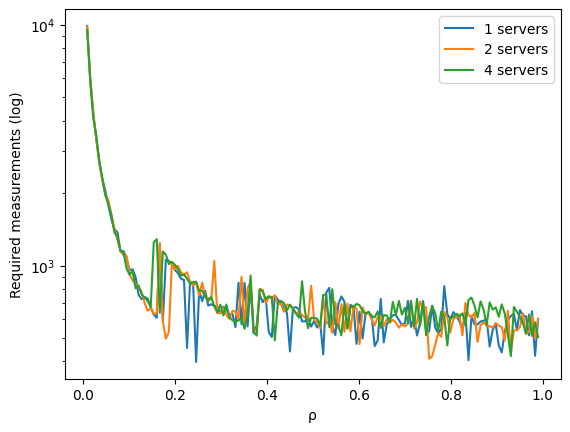

In [2]:
def queue_function(env, mu, waiting_times, queue): # Simulation for one single job
    
    while True:

        arrival_time = env.now # Register time at which job arrives
        
        with queue.request() as request:
            yield request # Join the queue
            waiting_times.append(env.now - arrival_time) # Calculate waiting time

            service_time = np.random.exponential(1 / mu) # Draw a random time from an exponential distribution with mean 1/mu ()
            yield env.timeout(service_time) # Add service time

def arrivals(env, lambda_, queue, mu, waiting_times): # Continuously create new jobs
    while True:
        yield env.timeout(np.random.exponential(1 / lambda_)) # Pause time until next arrival (randomly drawn from exponential distribution)
        env.process(queue_function(env, mu, waiting_times, queue)) # Start new process for new job

def simulation(lambda_, mu, servers, jobs):

    env = simpy.Environment() # Create general environment
    queue = simpy.Resource(env, capacity = servers) # Set number of servers
    waiting_times = []

    env.process(arrivals(env, lambda_, queue, mu, waiting_times)) # Start creating continuously new jobs

    env.run(until = jobs / lambda_) # Run simulation for expected time needed to get the number of jobs desired

    # Compute average waiting time and corresponding 95% confidence interval
    mean_waiting_time = np.mean(waiting_times)
    measurements = len(waiting_times)
    std_dev_waiting_time = np.std(waiting_times, ddof = 1)
    n = len(waiting_times)
    bound = z * (std_dev_waiting_time / np.sqrt(n))
    ci_low = mean_waiting_time - bound
    ci_high = mean_waiting_time + bound

    return mean_waiting_time, measurements, std_dev_waiting_time, (ci_low, ci_high)

# Set parameters
lambda_ = 2.95 # Arrival rate
mu = 3 # Servers capacity
jobs = 10000 # Number of jobs to be completed
z = norm.ppf(0.975) # Z for confidence interval

# Run simulation for 1, 2 and 4 servers
for servers in [1, 2, 4]:
    avg_waiting_time, measurements, std, confidence_interval = simulation(lambda_, mu, servers, jobs)
    print(f'Average waiting time for M/M/{servers}: {avg_waiting_time:.3f}')
    print(f'95% Confidence Interval: ({confidence_interval[0]:.3f}, {confidence_interval[1]:.3f})')

def measurements_required(target_error, rhos, mu, servers): # Calculate the number of jobs the system has to go through to reach the error desired in the estimation of the mean time

    results = []

    for rho in rhos: # Make the measurement dependent on a set of rho's

        lambda_ = rho * servers * mu # Derive Lambda
        error = float('inf') # To initiate the while loop
        jobs = 100

        while error > target_error: # Keep simulating as long as the compited error is larger than the desired one, increasing the number of jobs the system has to go through
            mean, measurements, std, ci = simulation(lambda_, mu, servers, jobs) 
            error = (z * (std / np.sqrt(measurements))) / mean # Calculate the current bound in the confidence interval
            jobs += 100
        
        results.append((rho, measurements))

    return results

rhos = np.linspace(0.01, 0.99, 150)

# Compute and plot the required number of measurements needed for different rho's and numbers of servers
for servers in [1, 2, 4]:
    print(f'Number of servers = {servers}')
    required_jobs = measurements_required(target_error = 0.05, rhos = rhos, mu = mu, servers = servers)
    jobs_list = []
    for rho, jobs in required_jobs:
        print(f'For ρ = {rho}, measurements required: {jobs}')
        jobs_list.append(jobs)
    plt.plot(rhos, jobs_list, label = f'{servers} servers')

plt.xlabel('ρ')
plt.ylabel('Required measurements (log)')
plt.yscale('log')
plt.legend()
plt.show


In [3]:
def queue_function_SJF(env, mu, waiting_times, queue): # Simulation for one single job
    
    while True:

        arrival_time = env.now # Register time at which job arrives
        service_time = np.random.exponential(1 / mu) # Draw a random time from an exponential distribution with mean 1/mu ()

        with queue.request(priority = service_time) as request:
            yield request # Join the queue
            waiting_times.append(env.now - arrival_time) # Calculate waiting time
            yield env.timeout(service_time) # Add service time

def arrivals_SJF(env, lambda_, queue, mu, waiting_times): # Continuously create new jobs
    while True:
        yield env.timeout(np.random.exponential(1 / lambda_)) # Pause time until next arrival (randomly drawn from exponential distribution)
        env.process(queue_function_SJF(env, mu, waiting_times, queue)) # Start new process for new job

def simulation_SJF(_SJFlambda_, mu, servers, jobs):

    env = simpy.Environment() # Create general environment
    queue = simpy.PriorityResource(env, capacity = servers) # Set number of servers
    waiting_times = []

    env.process(arrivals_SJF(env, lambda_, queue, mu, waiting_times)) # Start creating continuously new jobs

    env.run(until = jobs / lambda_) # Run simulation for expected time needed to get the number of jobs desired

    # Compute average waiting time and corresponding 95% confidence interval
    mean_waiting_time = np.mean(waiting_times)
    measurements = len(waiting_times)
    std_dev_waiting_time = np.std(waiting_times, ddof = 1)
    n = len(waiting_times)
    bound = z * (std_dev_waiting_time / np.sqrt(n))
    ci_low = mean_waiting_time - bound
    ci_high = mean_waiting_time + bound

    return mean_waiting_time, measurements, std_dev_waiting_time, (ci_low, ci_high)

# Set parameters
lambda_ = 2.95 # Arrival rate
mu = 3 # Servers capacity
jobs = 10000 # Number of jobs to be completed
z = norm.ppf(0.975) # Z for confidence interval
servers = 1
# Run simulation for 1, 2 and 4 servers
avg_waiting_time, measurements, std, confidence_interval = simulation_SJF(lambda_, mu, servers, jobs)
print(f'Average waiting time for M/M/{servers}: {avg_waiting_time:.3f}')
print(f'95% Confidence Interval: ({confidence_interval[0]:.3f}, {confidence_interval[1]:.3f})')

"""
# probably unnecessary
def measurements_required_SJF(target_error, rhos, mu, servers): # Calculate the number of jobs the system has to go through to reach the error desired in the estimation of the mean time

    results = []

    for rho in rhos: # Make the measurement dependent on a set of rho's

        lambda_ = rho * servers * mu # Derive Lambda
        error = float('inf') # To initiate the while loop
        jobs = 100

        while error > target_error: # Keep simulating as long as the compited error is larger than the desired one, increasing the number of jobs the system has to go through
            mean, measurements, std, ci = simulation_SJF(lambda_, mu, servers, jobs) 
            error = (z * (std / np.sqrt(measurements))) / mean # Calculate the current bound in the confidence interval
            jobs += 100
        
        results.append((rho, measurements))

    return results

rhos = np.linspace(0.01, 0.99, 100)
required_jobs = measurements_required_SJF(target_error = 0.1, rhos = rhos, mu = mu, servers = servers)
jobs_list = []
for rho, jobs in required_jobs:
    print(f'For ρ = {rho}, measurements required: {jobs}')
    jobs_list.append(jobs)
plt.plot(rhos, jobs_list, label = f'{servers} servers')

plt.xlabel('ρ')
plt.ylabel('Required measurements')
plt.legend()
plt.show
"""


Average waiting time for M/M/1: 3.801
95% Confidence Interval: (3.282, 4.321)


"\n# probably unnecessary\ndef measurements_required_SJF(target_error, rhos, mu, servers): # Calculate the number of jobs the system has to go through to reach the error desired in the estimation of the mean time\n\n    results = []\n\n    for rho in rhos: # Make the measurement dependent on a set of rho's\n\n        lambda_ = rho * servers * mu # Derive Lambda\n        error = float('inf') # To initiate the while loop\n        jobs = 100\n\n        while error > target_error: # Keep simulating as long as the compited error is larger than the desired one, increasing the number of jobs the system has to go through\n            mean, measurements, std, ci = simulation_SJF(lambda_, mu, servers, jobs) \n            error = (z * (std / np.sqrt(measurements))) / mean # Calculate the current bound in the confidence interval\n            jobs += 100\n        \n        results.append((rho, measurements))\n\n    return results\n\nrhos = np.linspace(0.01, 0.99, 100)\nrequired_jobs = measurements_